# Matching Pursuit 2D

X_GT, slow again, with real data

Import

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from skimage import draw
from scipy import signal
from PIL import Image
import pywt
import pywt.data
from utils_wavelet import *
import scipy.stats as stats

Functions

In [3]:
def fun_conv(A,B):
    conv = signal.fftconvolve(A,B,mode='same')
    return conv

def naive_conv(A,B):
    C = np.zeros(len(A))
    for i in range(len(A)):
        C[i] = np.sum(A*np.roll(np.roll(np.flip(B),1),i))
    return C

def manual_conv(A,B):
    C = np.zeros(len(A))
    for m in range(len(A)):
        for i in range(len(B)):
            C[m] += A[i]*B[m-i]
    return C

def fun_auto(A):
    auto = signal.fftconvolve(A,np.flip(A),mode='same')
    return auto

def imshowArray(arr):
    plt.imshow((arr,arr))
    plt.ylim([0,1])

def npArray2arrayList(a_vector):
    fake_a_coef = pywt.wavedec(a_vector,'db1')
    a_vector_array = vec2arrayList(a_vector,fake_a_coef)
    return a_vector_array

def npMatrix2arrayList(a_matrix):
    fake_a_coef = pywt.wavedec2(a_matrix,'db1')
    a_vector_array = vec2arrayList(a_matrix.flatten(),fake_a_coef)
    return a_vector_array

PSF vector h

In [4]:
global_factor = 4

def image_open(location):
    image_im = Image.open(location)
    realsize=image_im.size
    newsize=tuple(int(ti/global_factor) for ti in realsize)
    image_im=image_im.resize(newsize,Image.ANTIALIAS)
    image_im = np.array(image_im,dtype=float)
    image_im = image_im[:, :, 0]
    return image_im

def image_open_newsize(location,newsize):
    image_im = Image.open(location)
    image_im=image_im.resize(newsize,Image.ANTIALIAS)
    image_im = np.array(image_im,dtype=float)
    image_im = image_im[:, :, 0]
    return image_im

In [5]:
sx = 64
sy = 128

Import data

In [6]:
h = np.zeros((sx,sy))
h_black = np.zeros((sx,sy))
image = np.zeros((sx,sy))
backlight = np.zeros((sx,sy))
for i in range(1):
    h = image_open_newsize('from_camera/test17/h'+str(i)+'.png',(sy,sx))
    h_black = image_open_newsize('from_camera/test17/h_black'+str(i)+'.png',(sy,sx))
    image = image_open_newsize('from_camera/test17/image'+str(i)+'.png',(sy,sx))
    backlight = image_open_newsize('from_camera/test17/backlight'+str(i)+'.png',(sy,sx))
h /= 20
h_black /= 20   
image /= 20
backlight /= 20
h = np.flip(h-h_black)
y = np.flip(image-backlight)
# y /= np.linalg.norm(y)/0.99

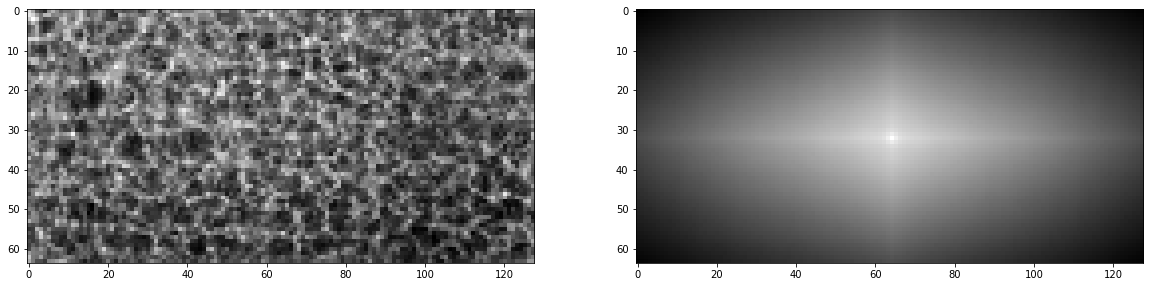

In [7]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.imshow(h,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(fun_auto(h),cmap='gray')
plt.show()

Offline computation

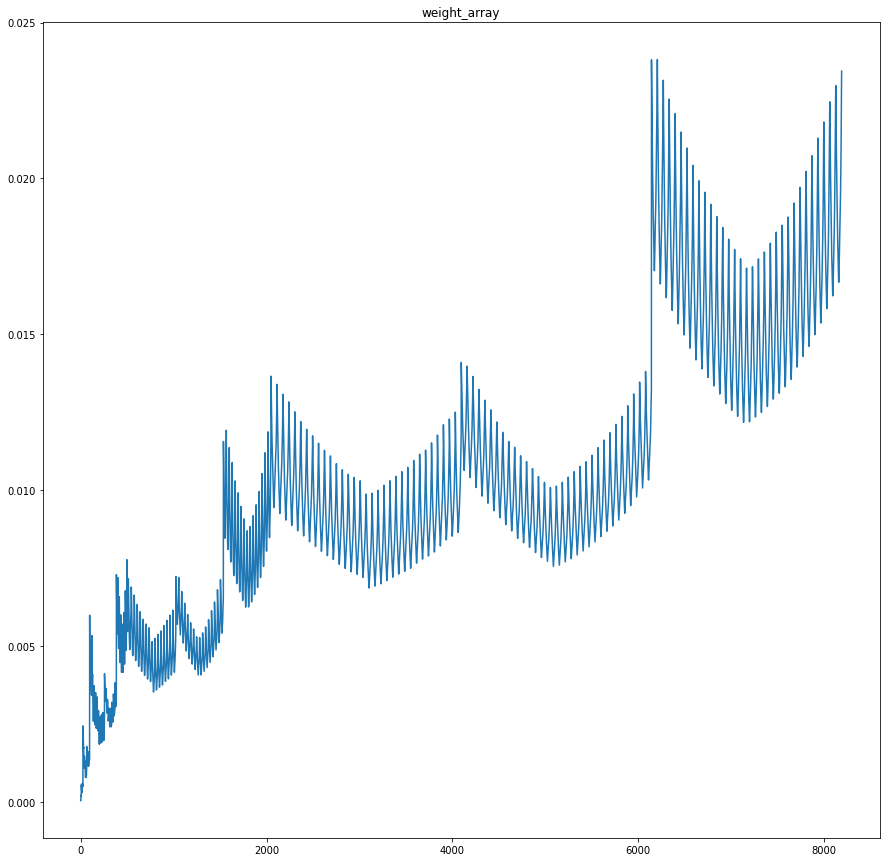

In [8]:
#Offline computation (about 20 seconds)
weight_array = np.zeros(sx*sy)

for i in range(sx*sy):
    #step 1
    e = np.zeros(sx*sy)
    e[i] = 1
    e = e.reshape(sx,sy)
    psi_i = pywt.waverec2(npMatrix2arrayList(e),'db1')
    #step 2
    theta_i = fun_conv(h,psi_i)
    #step 3
    weight_i = 1/np.linalg.norm(theta_i)
    weight_array[i] = weight_i

plt.figure(figsize=(15,15))
plt.plot(weight_array)
plt.title('weight_array')
plt.show()

Output vector x

MP loop (about 120 seconds)

In [14]:
r = np.copy(y)
a = np.zeros(sx*sy)
k = 0
s = 500
plotting_product = np.array([])
plotting_residue = np.array([])

while (k<s): 
    #atom selection
    arg2max_array = np.zeros(sx*sy)
    for i in range(sx*sy):
        e = np.zeros(sx*sy)
        e[i] = 1
        e = e.reshape(sx,sy)
        psi_i = pywt.waverec2(npMatrix2arrayList(e),'db1')
        theta_i = fun_conv(h,psi_i)
        arg2max = np.sum(theta_i*r)*weight_array[i]
        arg2max_array[i] = arg2max
    
    i_star = np.argmax(abs(arg2max_array))
    c = arg2max_array[i_star]
    print('c =',c)

    #coef. update
    a[i_star] = c

    #residual update
    e = np.zeros(sx*sy)
    e[i_star] = 1
    e = e.reshape(sx,sy)
    psi_i = pywt.waverec2(npMatrix2arrayList(e),'db1')
    theta_i = fun_conv(h,psi_i)
    r -= c*theta_i*weight_array[i_star]
    print('<r(k+1),Θ(i*)> = 0.0, ans:',np.sum(r*theta_i)*weight_array[i_star])

    #plotting elements
    plotting_product = np.append(plotting_product,c)
    plotting_residue = np.append(plotting_residue,np.linalg.norm(r))
    
    #next
    k += 1
    print('k ←',k)

# a *= weight_array
a_MP = a.reshape((sx,sy))
x_MP = pywt.waverec2(npMatrix2arrayList(a_MP),'db1')

c = 70.64285701304371
<r(k+1),Θ(i*)> = 0.0, ans: 3.910009257484807e-15
k ← 1
c = 37.59791909078793
<r(k+1),Θ(i*)> = 0.0, ans: 1.2520070636062577e-14
k ← 2
c = 20.16836554709225
<r(k+1),Θ(i*)> = 0.0, ans: -4.22627675360304e-15
k ← 3
c = -18.825190285386963
<r(k+1),Θ(i*)> = 0.0, ans: 5.446084322925266e-15
k ← 4
c = 15.307979562026672
<r(k+1),Θ(i*)> = 0.0, ans: -3.0024755721468146e-15
k ← 5
c = 12.860281857751037
<r(k+1),Θ(i*)> = 0.0, ans: 2.318325027204969e-15
k ← 6
c = -11.505505048360785
<r(k+1),Θ(i*)> = 0.0, ans: -1.3964318776731452e-16
k ← 7
c = 12.862191617502145
<r(k+1),Θ(i*)> = 0.0, ans: -7.277643476811664e-15
k ← 8
c = 10.691386985118028
<r(k+1),Θ(i*)> = 0.0, ans: -1.9782619356927378e-15
k ← 9
c = -7.5564186059216265
<r(k+1),Θ(i*)> = 0.0, ans: -5.099153431101894e-16
k ← 10
c = -8.213547635766329
<r(k+1),Θ(i*)> = 0.0, ans: 3.784196935047134e-15
k ← 11
c = -5.16082518235604
<r(k+1),Θ(i*)> = 0.0, ans: 2.11313837680152e-15
k ← 12
c = 5.836287574275764
<r(k+1),Θ(i*)> = 0.0, ans: -4.74

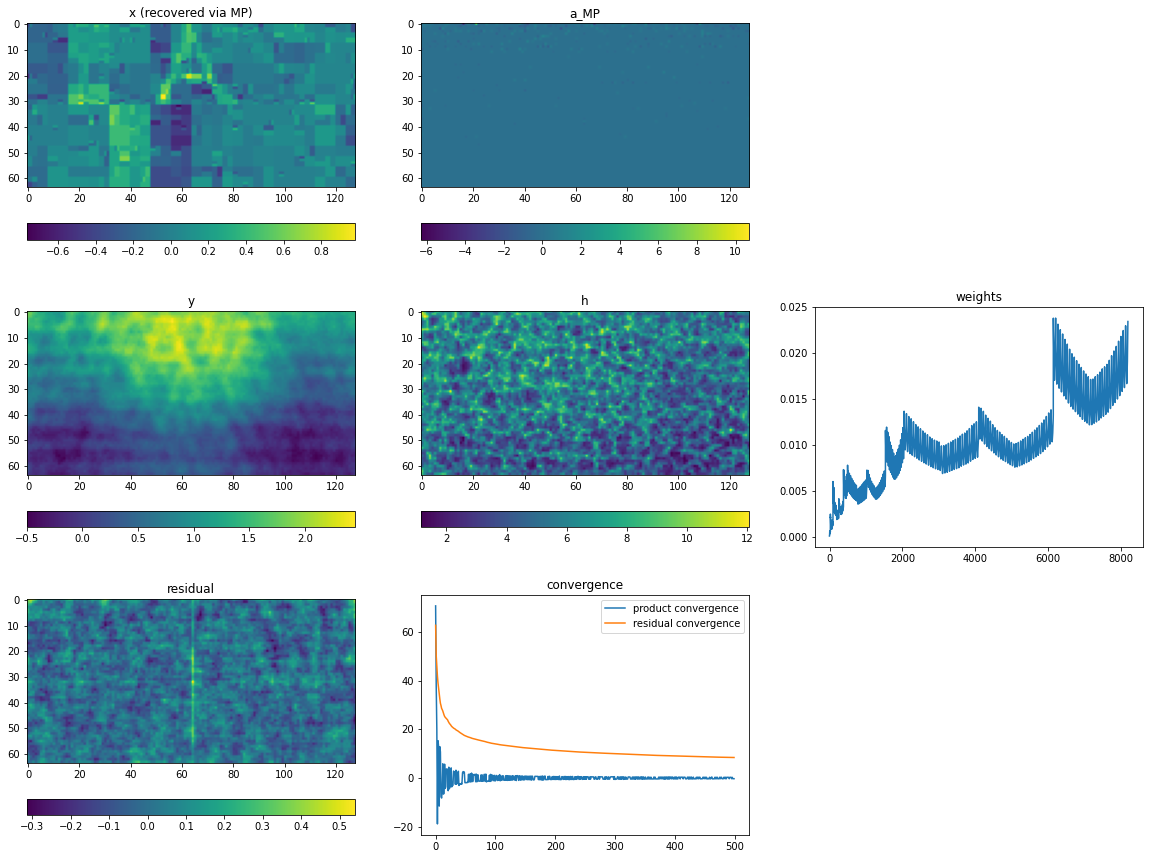

In [15]:
fig = plt.figure(figsize=(20,15))

# fig.add_subplot(3,4,1)
# plt.imshow(x_GT)
# plt.title('x (GT)')
# plt.colorbar(orientation="horizontal")


fig.add_subplot(3,3,1)
plt.imshow(x_MP)
plt.title('x (recovered via MP)')
plt.colorbar(orientation="horizontal")

# fig.add_subplot(3,4,3)
# plt.imshow(np.abs(x_GT-x_MP))
# plt.title('|x_GT - x_MP| = '+str(round(np.sum(np.abs(x_GT-x_MP)),2)))
# plt.colorbar(orientation="horizontal")

# fig.add_subplot(3,4,4)
# plt.imshow(x_GT*x_MP)
# error_pond = np.sum(x_GT*x_MP)/np.linalg.norm(x_GT)/np.linalg.norm(x_MP)
# plt.title('|<x_GT,x_MP>|/(||x_GT||·||x_MP||) = '+str(round(error_pond,2)))
# plt.colorbar(orientation="horizontal")

# fig.add_subplot(3,4,5)
# plt.imshow(alfa)
# plt.title('a "true"')
# plt.colorbar(orientation="horizontal")

fig.add_subplot(3,3,2)
plt.imshow(a_MP)
plt.title('a_MP')
plt.colorbar(orientation="horizontal")

fig.add_subplot(3,3,4)
plt.imshow(y)
plt.title('y')
plt.colorbar(orientation="horizontal")

fig.add_subplot(3,3,5)
plt.imshow(h)
plt.title('h')
plt.colorbar(orientation="horizontal")

fig.add_subplot(3,3,6)
plt.plot(weight_array)
plt.title('weights')

fig.add_subplot(3,3,7)
plt.imshow(r)
plt.title('residual')
plt.colorbar(orientation="horizontal")

fig.add_subplot(3,3,8)
plt.plot(plotting_product,'-',label='product convergence')
plt.plot(plotting_residue,'-',label='residual convergence')
plt.legend()
plt.title('convergence')

plt.savefig('resultats/mp_2dqqqq.png', bbox_inches='tight')
plt.show()